<a href="https://colab.research.google.com/github/nanunzoey/aiffel_projects/blob/master/semiconductor_manufacturing_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **제조 공정 이상 탐지 Manufacturing Anomaly Detection**

A complex modern semiconductor manufacturing process is normally under constant
surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system.

![image](https://user-images.githubusercontent.com/80008411/139516620-676ef18f-0b10-4448-bee7-8ef0eca1d403.png)


### 목적 Objective
- To build a classifier to predict the Pass/Fail yield of a particular process entity.
- To analyze whether all the features are required to build the model or not, trying out different combinations of features.

### 데이터 개요 Dataset Description
- [UCI semiconductor manufacturing sensor data.](https://www.kaggle.com/saurabhbagchi/fmst-semiconductor-manufacturing-project/data)
- 1,567 examples each with 591 features.
- Target column '-1' corresponds to a pass and '1' corresponds to a fail.

### Learning Outcomes
- Feature Importance
- Exploratory Data Analysis
- Grid Search
- PCA
- Autoencoder
- Logistic Regression
- Random Forest
- Xgboost


## Import Libraries

In [64]:
# for basic operations
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# for preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from keras import regularizers

# for better model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# for modeling
import tensorflow as tf
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adadelta

# for evaluation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# to avoid warnings
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2021)

## Reading Data and Understanding the attributes

In [2]:
# for providing path
file_path = '/content/drive/MyDrive/AIFFEL/uci-secom.csv'

In [3]:
data = pd.read_csv(file_path)

print(data.shape)
data.head()

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# check missing values
data.isnull().any().any()

True

In [5]:
# replace all the NaN values with 0
data = data.replace(np.NaN, 0)

# check again
data.isnull().any().any()

False

In [6]:
# check balance of label data
data['Pass/Fail'].value_counts(normalize=True)

-1    0.933631
 1    0.066369
Name: Pass/Fail, dtype: float64

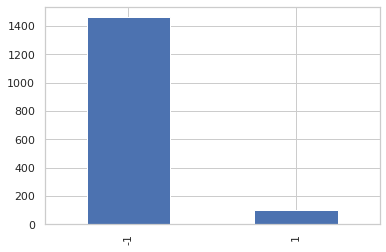

In [7]:
data['Pass/Fail'].value_counts().plot(kind='bar')

## Remove Correlational & Collinear Features

In [8]:
# correlation matrix
corr = data.corr()

# since the correlation is too big so have exported as csv file
corr.to_csv('correlation.csv')

Text(0.5, 1.0, 'Correlation heatmap for the Data')

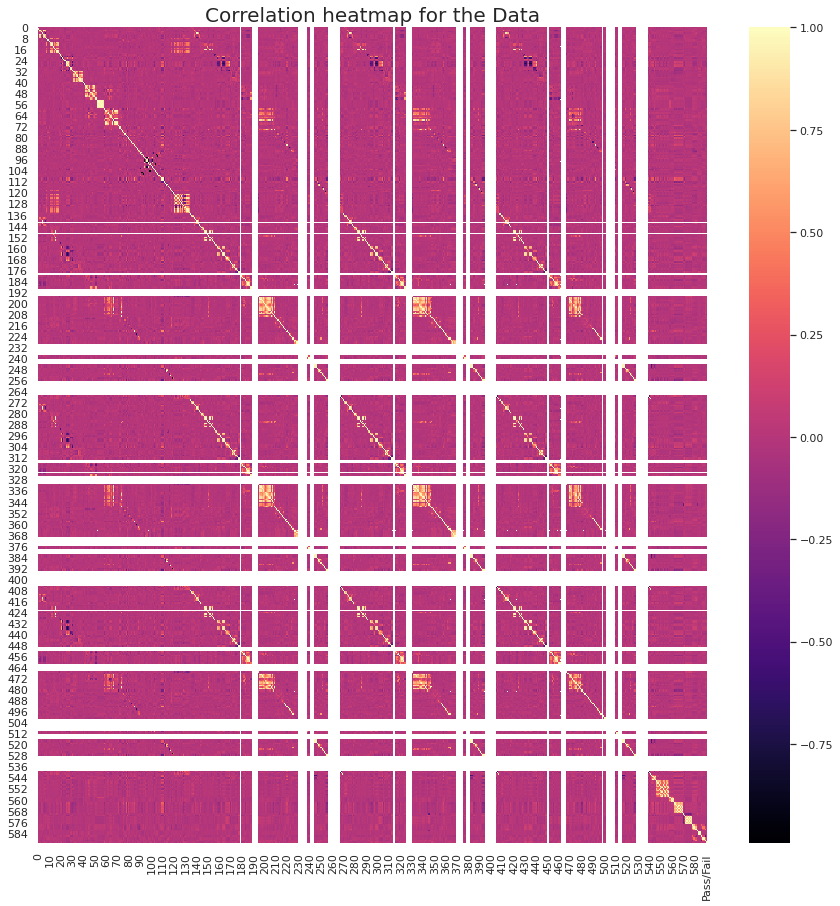

In [9]:
# heatmap to get correlation
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(corr, cmap = "magma")
plt.title('Correlation heatmap for the Data', fontsize = 20)

In [10]:
# based on correlation, a lot of columns are having same value through and no variance which are shown as blank values.
# remove such columns (116 columns)
data.drop(['5','13','42','49','52','69','97','141',
  '149','178','179','186','189','190','191','192',
  '193','194','226','229','230','231','232','233',
  '234','235','236','237','240','241','242','243',
  '256','257','258','259','260','261','262','263',
  '264','265','266','276','284','313','314','315',
  '322','325','326','327','328','329','330','364',
  '369','370','371','372','373','374','375','378',
  '379','380','381','394','395','396','397','398',
  '399','400','401','402','403','404','414','422',
  '449','450','451','458','461','462','463','464',
  '465','466','481','498','501','502','503','504',
  '505','506','507','508','509','512','513','514',
  '515','528','529','530','531','532','533','534',
  '535','536','537','538'], axis=1, inplace=True)

In [11]:
data.shape

(1567, 476)

In [12]:
#Remove the highly collinear features from results dataframe
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    print('Removing:\n')
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [13]:
# Remove columns having more than 0% correlation
# Both positive and negative correlations are considered here
final_data = remove_collinear_features(data, 0.8)

Removing:

6 | 2 | 0.82
12 | 11 | 0.83
17 | 11 | 0.81
18 | 17 | 0.9
26 | 25 | 0.83
27 | 25 | 0.98
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 37 | 0.86
39 | 38 | 0.84
46 | 43 | 0.84
50 | 43 | 0.9
50 | 46 | 0.97
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
70 | 60 | 0.97
70 | 61 | 0.85
70 | 66 | 0.99
70 | 68 | 0.88
73 | 72 | 0.98
96 | 94 | 0.96
98 | 94 | 0.84
98 | 96 | 0.87
101 | 98 | 0.91
104 | 99 | 0.99
105 | 92 | 0.99
106 | 93 | 0.99
110 | 109 | 1.0
111 | 109 | 1.0
111 | 110 | 1.0
123 | 121 | 1.0
124 | 121 | 1.0
124 | 123 | 1.0
127 | 122 | 0.97
131 | 121 | 1.0
131 | 123 | 0.99
131 | 124 | 0.99
132 | 121 | 0.89
132 | 123 | 0.89
132 | 124 | 0.89
132 | 131 |

In [14]:
final_data.shape

(1567, 219)

## Data Visualization

In [15]:
# check unique label data
unique_label = final_data['Pass/Fail'].unique()

targets = [final_data.loc[final_data['Pass/Fail'] == label] for label in unique_label]

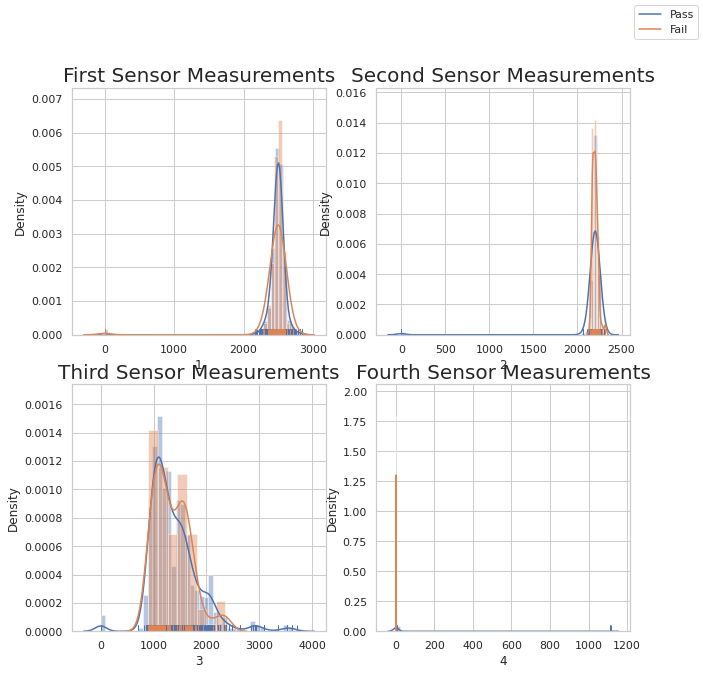

In [16]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize=20)

fig.legend(labels=['Pass','Fail'])
plt.show()

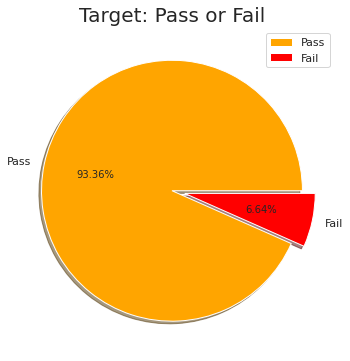

In [17]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass
labels = ['Pass', 'Fail']
size = final_data['Pass/Fail'].value_counts()
colors = ['orange', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, labels=labels, colors=colors, explode=explode, autopct="%.2f%%", shadow=True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize=20)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation heatmap for the Data')

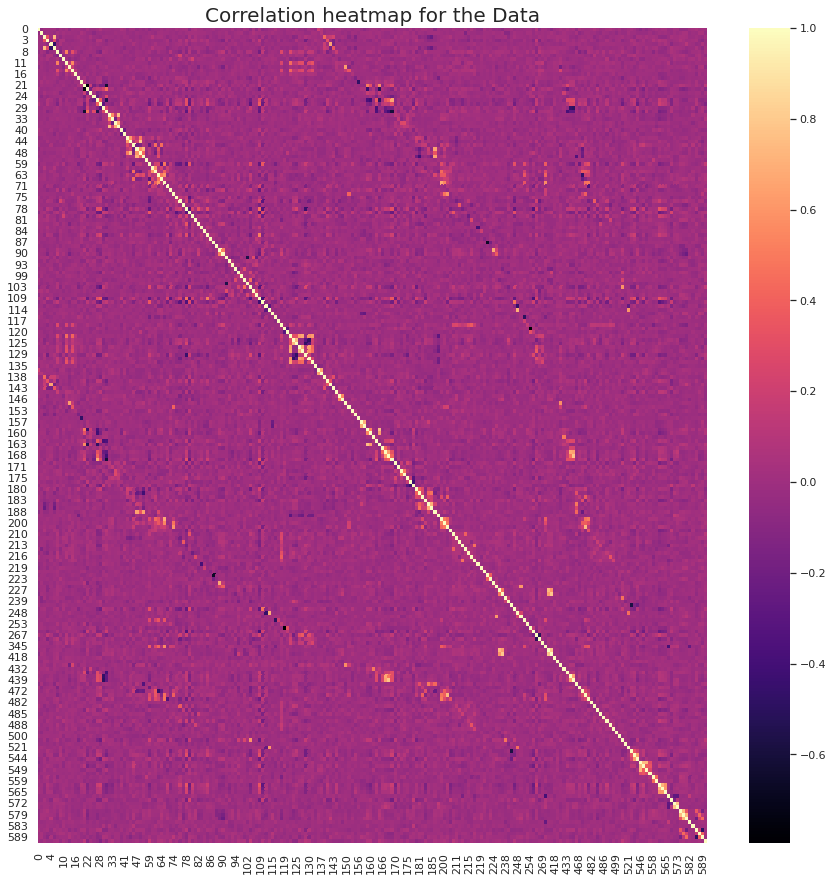

In [18]:
# heatmap to get correlation
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(final_data.corr(), cmap = "magma") #YlGnBu
plt.title('Correlation heatmap for the Data', fontsize = 20)

## Feature Extraction (1) PCA



In [19]:
final_data.head()

,Time,0,1,2,3,4,7,8,9,10,11,14,15,16,19,20,21,22,23,24,25,28,29,31,32,33,36,37,40,41,43,44,45,47,48,51,53,59,60,62,...,474,476,482,483,484,485,486,487,488,489,499,500,510,511,521,542,543,544,546,547,549,551,558,559,562,564,565,570,571,572,573,578,579,581,582,583,586,587,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,0.1242,1.5005,0.0162,-0.0034,0.9455,7.9558,414.8710,10.0433,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,64.2333,2.0222,3.5191,83.3971,9.5126,49.3830,66.3141,61.29,4.515,352.7173,10.1841,130.3691,1.3072,141.2282,218.3174,4.592,-1.7264,350.9264,108.6427,...,13.6778,31.9893,613.3069,291.4842,494.6996,178.1759,843.1138,0.0000,53.1098,0.0000,0.0000,0.0000,64.6707,0.0000,0.0,0.1096,0.0078,0.0026,1.0616,395.570,0.4234,0.78,1.0344,0.4385,0.000,0.00,0.0000,533.8500,2.1113,8.95,0.3157,0.0000,0.0000,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,0.1247,1.4966,-0.0005,-0.0148,0.9627,10.1548,414.7347,9.2599,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,68.4222,2.2667,3.4171,84.9052,9.7997,49.3404,64.9193,78.25,2.773,352.2445,10.0373,133.1727,1.2887,145.8445,205.1695,4.590,0.8073,352.0073,113.9800,...,13.2430,30.8643,0.0000,246.7762,0.0000,359.0444,130.6350,820.7900,194.4371,0.0000,0.0000,0.0000,141.4365,0.0000,0.0,0.1096,0.0078,0.0026,1.3526,408.798,0.7193,1.33,0.9634,0.1745,0.000,0.00,0.0000,535.0164,2.4335,5.92,0.2653,0.0096,0.0201,208.2045,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,0.1241,1.4436,0.0041,0.0013,0.9615,9.5157,416.7075,9.3144,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,67.1333,2.3333,3.5986,84.7569,8.6590,49.8470,65.8389,14.37,5.434,364.3782,9.8783,131.8027,1.2992,141.0845,185.7574,4.486,23.8245,364.5364,115.6273,...,45.5423,13.3923,434.2674,151.7665,0.0000,190.3869,746.9150,74.0741,191.7582,250.1742,0.0000,0.0000,240.7767,244.2748,0.0,0.1096,0.0078,0.0026,0.7942,411.136,0.1832,0.85,1.5021,0.3718,267.064,1.10,0.6219,535.0245,2.0293,11.21,0.1882,0.0584,0.0484,82.8602,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,0.1217,1.4882,-0.0124,-0.0033,0.9629,9.6052,422.2894,9.6924,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,62.9333,2.6444,3.3813,84.9105,8.6789,49.4900,65.1951,76.90,1.279,363.0273,9.9305,131.8027,1.3027,142.5427,189.9079,4.486,24.3791,361.4582,116.1818,...,48.4887,35.4323,225.0169,100.4883,305.7500,88.5553,104.6660,71.7583,0.0000,336.7660,0.0000,711.6418,113.5593,0.0000,0.0,0.1096,0.0078,0.0026,1.1650,372.822,1.8804,39.33,1.1613,0.7288,268.228,7.32,0.1630,530.5682,2.0253,9.33,0.1738,0.0202,0.0149,73.8432,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,0.1235,1.5031,-0.0031,-0.0072,0.9569,10.5661,420.5925,10.3387,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,62.8333,3.1556,3.2728,86.3269,8.7677,49.7520,66.1542,76.39,2.209,353.3400,10.4091,176.3136,1.0341,138.0882,233.5491,4.624,-12.2945,355.0809,144.0191,...,19.1303,42.6838,171.4486,276.8810,461.8619,240.1781,0.0000,587.3773,748.1781,0.0000,293.1396,0.0000,148.0663,0.0000,0.0,0.1096,0.0078,0.0026,1.4636,399.914,1.0388,1.98,0.9778,0.2156,0.000,0.00,0.0000,532.0155,2.0275,8.83,0.2224,0.0000,0.0000,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [20]:
# drop Time column
final_data.drop('Time', axis = 1, inplace=True)

final_data.shape

(1567, 218)

In [21]:
# sc = MinMaxScaler()
# sc.fit(X)
# scaled_X = sc.transform(X)

# scaled_X

In [22]:
pass_data = final_data[final_data['Pass/Fail'] == -1]
fail_data = final_data[final_data['Pass/Fail'] == 1]

df = pass_data.append(fail_data).sample(frac=1).reset_index(drop=True)

X = df.drop(['Pass/Fail'], axis= 1).values
Y = df["Pass/Fail"].values

In [28]:
X.shape

(1567, 217)

Number of dimensions needed to capture 95% of variance: 5


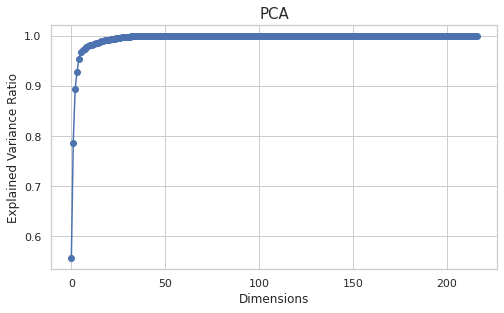

In [37]:
pca = PCA(n_components=X.shape[1]).fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('Number of dimensions needed to capture 95% of variance:', d)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(cumsum,'-o')
plt.title('PCA', fontsize=15)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [38]:
# PCA with reduced number of components
pca = PCA(n_components=0.95)
dim_reduced = pca.fit_transform(X)

pca_df = pd.DataFrame(dim_reduced, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])
pca_df.head()

,pc1,pc2,pc3,pc4,pc5
0,8208.608670,-2651.976586,340.279715,-832.394181,272.628122
1,1322.261967,-754.516596,6993.015394,-1159.024698,426.693680
2,8046.651086,-3195.568851,-12370.371746,-965.798908,-433.143053
3,8793.291028,-3526.247219,-5405.136347,-901.023862,-145.508450
4,-4676.297765,-3563.500560,216.155207,-197.589997,-49.375503


In [39]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4))
components.index = dimensions

components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216
Dimension 1,0.0004,0.0008,-0.0009,0.0025,-0.0002,-0.0,-0.0,-0.0,-0.0,0.0,-0.0000,0.0002,-0.0,0.0,0.0,0.0161,-0.0051,-0.0015,-0.0736,0.0,0.0001,-0.0,-0.0000,-0.0000,-0.0,0.0,0.0,-0.0002,-0.0000,-0.0001,0.0,-0.0000,0.0,0.0000,-0.0000,0.0,-0.0002,-0.0002,-0.0000,-0.0000,...,0.0001,-0.0000,-0.0002,-0.0017,0.0016,-0.0026,-0.0001,0.0010,0.0040,-0.0001,0.0001,0.0003,0.0003,-0.0004,0.0012,-0.0007,0.0,0.0,-0.0,0.0,0.0010,-0.0,0.0,-0.0,-0.0,0.0015,0.0000,0.0,0.0000,-0.0,0.0003,-0.0,-0.0,-0.0,-0.0002,0.0,-0.0,0.0,-0.0,-0.0004
Dimension 2,0.0011,0.0002,0.0012,-0.0006,-0.0002,0.0,0.0,-0.0,0.0,-0.0,-0.0000,0.0002,-0.0,0.0,0.0,-0.0118,0.0061,0.0468,-0.0116,-0.0,-0.0000,0.0,0.0000,-0.0000,-0.0,0.0,0.0,0.0000,-0.0000,-0.0001,-0.0,-0.0001,-0.0,-0.0000,-0.0004,-0.0,0.0000,0.0000,-0.0000,-0.0000,...,-0.0001,-0.0001,0.0000,0.0020,0.0000,0.0002,-0.0012,-0.0005,0.0008,0.0029,-0.0005,-0.0043,0.0007,-0.0001,0.0034,-0.0003,0.0,-0.0,0.0,0.0,-0.0009,0.0,-0.0,-0.0,-0.0,-0.0004,-0.0000,-0.0,-0.0000,-0.0,0.0001,-0.0,-0.0,-0.0,0.0000,0.0,-0.0,-0.0,0.0,0.0003
Dimension 3,-0.0010,-0.0046,-0.0012,-0.0077,-0.0003,-0.0,0.0,0.0,-0.0,-0.0,0.0000,0.0003,0.0,-0.0,-0.0,-0.0354,0.0114,0.0185,0.9957,-0.0,-0.0000,-0.0,0.0000,-0.0000,0.0,0.0,-0.0,0.0003,-0.0000,0.0000,0.0,-0.0001,-0.0,0.0000,0.0003,0.0,0.0001,-0.0000,-0.0000,-0.0000,...,0.0003,0.0000,0.0001,0.0025,0.0031,0.0042,0.0034,-0.0006,-0.0062,-0.0020,0.0011,-0.0018,0.0004,-0.0004,0.0017,0.0007,-0.0,-0.0,0.0,-0.0,-0.0039,0.0,-0.0,-0.0,-0.0,-0.0007,-0.0000,-0.0,0.0002,0.0,-0.0005,-0.0,-0.0,-0.0,-0.0009,-0.0,-0.0,0.0,-0.0,-0.0007
Dimension 4,-0.0010,-0.0006,0.0025,0.0360,-0.0002,0.0,-0.0,-0.0,-0.0,0.0,0.0003,0.0006,0.0,0.0,-0.0,-0.0111,-0.0101,-0.0296,0.0299,0.0,0.0003,-0.0,0.0000,-0.0001,-0.0,0.0,-0.0,0.0001,-0.0001,0.0002,-0.0,0.0005,-0.0,-0.0001,0.0008,0.0,-0.0003,0.0005,0.0006,-0.0004,...,0.0015,0.0009,-0.0003,-0.0053,0.0065,-0.0081,-0.0031,-0.0099,0.0093,-0.0136,-0.0109,-0.0008,-0.0009,-0.0019,0.0021,0.0004,0.0,-0.0,-0.0,0.0,0.0062,-0.0,0.0,0.0,0.0,0.0045,0.0001,0.0,0.0003,-0.0,-0.0019,0.0,0.0,0.0,0.0100,0.0,0.0,-0.0,-0.0,0.0033
Dimension 5,0.0025,0.0019,-0.0064,0.0014,-0.0003,-0.0,-0.0,0.0,0.0,0.0,-0.0001,0.0002,0.0,-0.0,-0.0,-0.1834,0.0760,-0.9185,0.0056,0.0,0.0004,0.0,0.0001,0.0000,0.0,0.0,0.0,0.0003,-0.0000,-0.0005,-0.0,-0.0002,0.0,-0.0003,-0.0025,0.0,-0.0001,-0.0005,0.0000,-0.0002,...,0.0006,0.0002,-0.0000,-0.0037,0.0030,-0.0017,0.0002,-0.0067,-0.0008,0.0035,-0.0012,-0.0014,-0.0089,-0.0012,0.0010,0.0015,-0.0,-0.0,-0.0,0.0,0.0031,0.0,0.0,-0.0,0.0,0.0014,0.0001,-0.0,0.0002,-0.0,-0.0013,-0.0,-0.0,-0.0,-0.0004,-0.0,-0.0,-0.0,-0.0,0.0019


In [40]:
# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = dimensions

variance_ratios

,Explained Variance
Dimension 1,0.5564
Dimension 2,0.2307
Dimension 3,0.1061
Dimension 4,0.0340
Dimension 5,0.0260


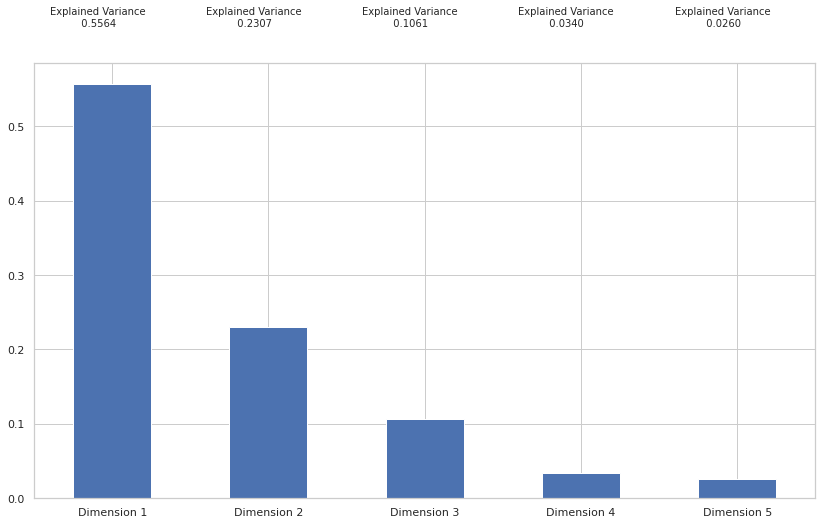

In [41]:
# Create a bar plot visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the feature weights as a function of the components
variance_ratios.plot(ax=ax, kind='bar', legend=False)
ax.set_xticklabels(dimensions, rotation=0)

# Display the explained variance ratios
for i, ev in enumerate(pca.explained_variance_ratio_):
    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n{:^27.4f}".format(ev))

In [42]:
pca_df['label'] = final_data['Pass/Fail']
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,label
0,8208.608670,-2651.976586,340.279715,-832.394181,272.628122,-1
1,1322.261967,-754.516596,6993.015394,-1159.024698,426.693680,-1
2,8046.651086,-3195.568851,-12370.371746,-965.798908,-433.143053,1
3,8793.291028,-3526.247219,-5405.136347,-901.023862,-145.508450,-1
4,-4676.297765,-3563.500560,216.155207,-197.589997,-49.375503,-1


In [43]:
pca_df.shape

(1567, 6)

## Feature Extraction (2) TSNE, AutoEncoder

In [49]:
tsne = TSNE(n_components=2, random_state=2021)
tsne_data = tsne.fit_transform(X)

In [50]:
tsne_data

array([[-21.032063 , -30.079132 ],
       [ -2.8365688, -24.440657 ],
       [-36.35507  , -20.514204 ],
       ...,
       [-48.143227 ,  30.0636   ],
       [  5.7636476,  48.68141  ],
       [  5.905701 ,  26.57295  ]], dtype=float32)

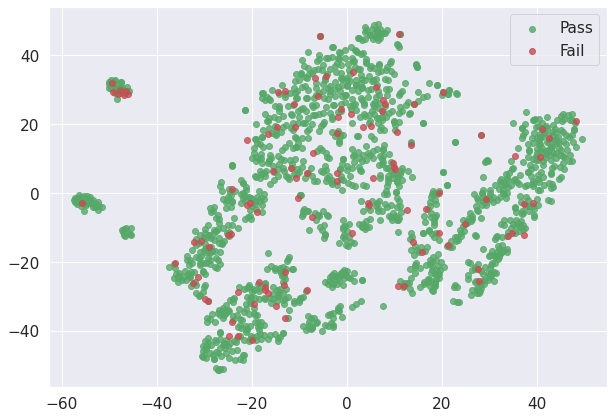

In [52]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[np.where(Y == -1), 0], tsne_data[np.where(Y == -1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Pass')
plt.scatter(tsne_data[np.where(Y == 1), 0], tsne_data[np.where(Y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fail')

plt.legend(loc='best')
plt.grid()
plt.show()

In [53]:
pass_data.drop('Pass/Fail', axis=1, inplace=True)
fail_data.drop('Pass/Fail', axis=1, inplace=True)

In [54]:
# input layer 
input_layer = Input(shape=(X.shape[1],))

# encoding part
encoded = Dense(100, activation='tanh')(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [70]:
autoencoder = Model(input_layer, output_layer)

op = Adadelta(lr=100)
autoencoder.compile(optimizer=op, loss="mse")

In [71]:
history = autoencoder.fit(pass_data, pass_data, batch_size=128, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 39ms/step - loss: 709826.4375 - val_loss: 714006.6875
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 699264.8125 - val_loss: 704740.1875
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 689354.3750 - val_loss: 697294.9375
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 680737.0625 - val_loss: 690268.9375
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 672588.6875 - val_loss: 684227.2500
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 665201.6250 - val_loss: 678339.1250
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 658317.5625 - val_loss: 672557.1875
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 651860.7500 - val_loss: 668134.3750
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 645977.7500 - val_loss: 663384.4375
Epoch 10/100
10/10

In [72]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [73]:
pass_hid_rep = hidden_representation.predict(pass_data)
fail_hid_rep = hidden_representation.predict(fail_data)

In [74]:
rep_x = np.append(pass_hid_rep, fail_hid_rep, axis=0)
y_n = np.zeros(pass_hid_rep.shape[0])
y_f = np.ones(fail_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [75]:
tsne = TSNE(n_components=2, random_state=2021)
tsne_data = tsne.fit_transform(rep_x)

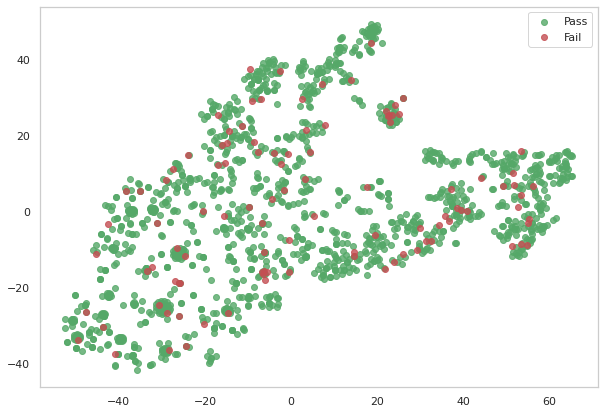

In [77]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[np.where(rep_y == 0), 0], tsne_data[np.where(rep_y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Pass')
plt.scatter(tsne_data[np.where(rep_y == 1), 0], tsne_data[np.where(rep_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fail')

plt.legend(loc='best')
plt.grid()
plt.show()

## Model Design & Train

### (1) PCA

In [44]:
x_train, x_test, y_train, y_test = train_test_split(pca_df.drop('label', axis=1), pca_df['label'], test_size=0.2, random_state=2021)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1253, 5)
shape of x_test:  (314, 5)
shape of y_train:  (1253,)
shape of y_test:  (314,)


In [45]:
pca_model = LogisticRegression(random_state=2021)

In [46]:
pca_model.fit(x_train, y_train) 
y_pred = pca_model.predict(x_test)

In [47]:
def evaluate_model(model, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.rcParams['figure.figsize'] = (5, 5)
  sns.set(style='dark', font_scale=1.4)
  sns.heatmap(cm, annot=True, annot_kws={"size": 15})

  print(f"Accuracy: {model.score(x_test, y_test)*100:.2f}%\n")

Accuracy: 94.59%



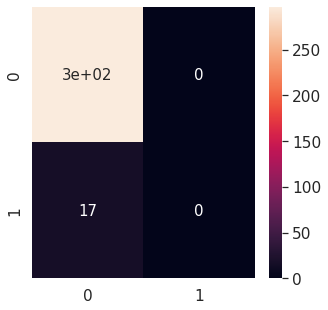

In [48]:
evaluate_model(pca_model, y_test, y_pred)

### (2) TSNE, AutoEncoder

In [78]:
x_train, x_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size=0.2)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1253, 50)
shape of x_test:  (314, 50)
shape of y_train:  (1253,)
shape of y_test:  (314,)


In [79]:
ae_model = LogisticRegression(random_state=2021)

In [80]:
ae_model.fit(x_train, y_train) 
y_pred = ae_model.predict(x_test)

Accuracy: 93.63%



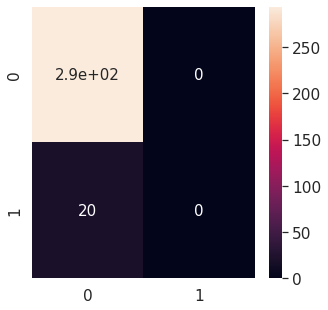

In [81]:
evaluate_model(ae_model, y_test, y_pred)